In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
manifest = {}
with open("manifest.txt","r") as mn:
    lines = mn.read().split('\n')
    for l in lines:
        lfile = l.split()
        if len(lfile)>0:
            manifest[lfile[0]] = lfile[1]

In [3]:
names = sorted(manifest.keys())
ix = 0
for n in names:
    print ix,n
    ix+=1

0 andesitefine
1 andesitesolid
2 basaltsolid
3 brownsand
4 clearice
5 coarsesnow
6 dunesand
7 finesnow
8 frost
9 mediumsnow
10 seawater
11 tapwater
12 yellowloam
13 yellowsand


In [4]:
ids = [0,1,2,3,6,12,13]

In [5]:
for i in ids:
    print names[i]

andesitefine
andesitesolid
basaltsolid
brownsand
dunesand
yellowloam
yellowsand


In [6]:
weights = np.zeros(len(ids))+1.0/7.0
weights[4] /= 2.0
weights[0:4] += weights[4]/6.0
weights[5:] += weights[4]/6.0
offset = weights[0]*0.5
weights[0:2] += offset
weights[2:4] -= 2*offset/4.0
weights[5:]  -= 2*offset/4.0
offset = weights[2]*0.7
weights[2] += offset
weights[:2] -= offset/5.0
weights[3] -= offset/5.0
weights[5:] -= offset/5.0
weights[0] *= 2.0
weights[1:] -= 0.5*weights[0]/6.0

In [7]:
print np.sum(weights),weights

1.0 [0.43178571 0.17991071 0.16133929 0.06383929 0.03544643 0.06383929
 0.06383929]


In [8]:
wvref = np.loadtxt("wvref.txt")

In [9]:
print wvref.shape

(965,)


In [10]:
specs = np.zeros((len(ids),wvref.shape[0]))


In [11]:
for idn in range(len(ids)):
    filename = manifest[names[ids[idn]]]
    with open(filename,"r") as fileobj:
        text = fileobj.read().split('\n')
        for k in range(len(text)):
            if text[k].split()[0]=="Additional":
                nhead = k+2
                break
    spec = np.loadtxt(filename,skiprows=nhead,ndmin=2).transpose()
    if spec[0,0] > spec[0,-1]:
        spec = np.flip(spec,axis=1)
    specs[idn,:] = np.interp(wvref,spec[0,:],spec[1,:])

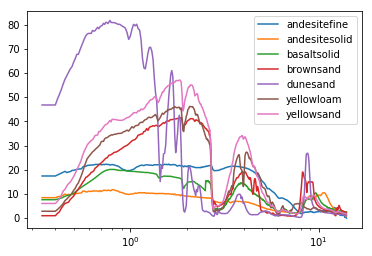

In [12]:
for idn in range(len(ids)):
    plt.plot(wvref,specs[idn,:],label=names[ids[idn]])
plt.xscale('log')
plt.legend()

In [13]:
wtspec = np.copy(specs)
for n in range(len(ids)):
    wtspec[n,:] *= weights[n]

In [14]:
netspec = np.sum(wtspec,axis=0)

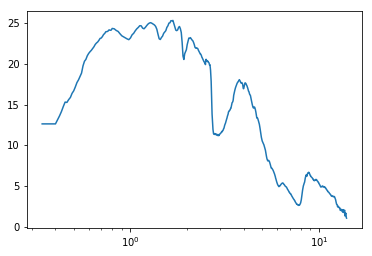

In [15]:
plt.plot(wvref,netspec)
plt.xscale('log')

(0.34, 14.01)

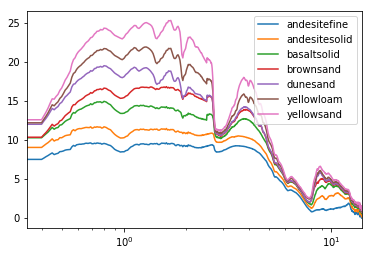

In [16]:
for n in range(len(ids)):
    plt.plot(wvref,np.sum(wtspec[:n+1,:],axis=0),label=names[ids[n]])
plt.xscale('log')
plt.legend()
plt.xlim(wvref.min(),wvref.max())

In [17]:
import colormatch as cm

In [18]:
print np.sum(weights)

1.0


In [19]:
def bbtemp(teff,wvref):
    sbk = 5.67e-8
    const = 0.0143877735383
    bbf = 1.0/wvref**5 * (1.0/(np.exp(const/(teff*wvref*1e-6))-1))
    return bbf

In [20]:
rgbs = []
srgbs = []
albs = []
stemps = np.linspace(2800,7900,num=18)
print stemps
bbs = []
for s in range(0,len(stemps)):
    bbf = bbtemp(stemps[s],wvref)
    bbs.append(bbtemp(stemps[s]-650.0,wvref))
    refl = netspec*0.01*bbf
    albb = np.trapz(refl[:145],x=wvref[:145])/np.trapz(bbf[:145],x=wvref[:145])
    albs.append(albb)
    #srgbs.append(cm.specs2rgb(wvref*1e3,[bbf,]))
    rgbs.append(cm.spec2rgb(wvref*1e3,refl,normalization=albb))
srgbs = cm.specs2rgb(wvref*1e3,np.array(bbs))

[2800. 3100. 3400. 3700. 4000. 4300. 4600. 4900. 5200. 5500. 5800. 6100.
 6400. 6700. 7000. 7300. 7600. 7900.]


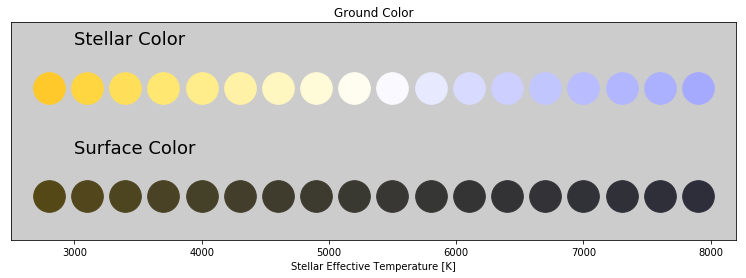

In [21]:
fig,ax=plt.subplots(figsize=(13,4))
for s in range(len(stemps)):
    plt.scatter(stemps[s],1.0,marker='o',color=np.array(rgbs[s])/np.mean(rgbs[s])*albs[s],s=1000)
    plt.scatter(stemps[s],1.25,marker='o',color=np.array(srgbs[s])/np.amax(srgbs[s]),s=1000)
    #plt.annotate("%d K"%stemps[s],(stemps[s]-100,1.35))
    #print stemps[s]
    #plt.axvline(stemps[s])
ax.set_facecolor('0.8')
plt.annotate("Stellar Color",(3000,1.35),color='k',fontsize=18)
plt.annotate("Surface Color",(3000,1.1),color='k',fontsize=18)
plt.ylim(0.9,1.4)
plt.xlim(2500,8200)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)
plt.xlabel("Stellar Effective Temperature [K]")
plt.title("Ground Color")
plt.savefig("colorgrid.png",bbox_inches='tight')

In [22]:
alb1 = np.zeros(100)
alb2 = np.zeros(100)
albb = np.zeros(100)
teffs = np.linspace(2700,6000,num=100)

In [23]:
for n in range(100):
    bbf = bbtemp(teffs[n],wvref)
    refl = netspec*0.01*bbf
    alb1[n] = np.trapz(refl[:42],x=wvref[:42])/np.trapz(bbf[:42],x=wvref[:42])
    alb2[n] = np.trapz(refl[42:145],x=wvref[42:145])/np.trapz(bbf[42:145],x=wvref[42:145])
    albb[n] = np.trapz(refl[:145],x=wvref[:145])/np.trapz(bbf[:145],x=wvref[:145])

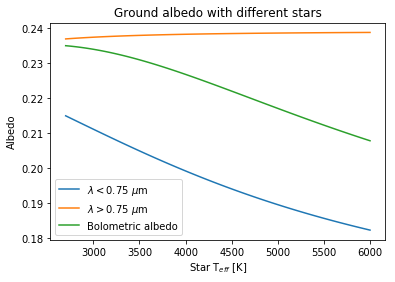

In [24]:
plt.plot(teffs,alb1,label="$\lambda<{0.75}$ $\mu$m")
plt.plot(teffs,alb2,label="$\lambda>{0.75}$ $\mu$m")
plt.plot(teffs,albb,label='Bolometric albedo')
plt.legend(loc='best')
plt.xlabel("Star T$_{eff}$ [K]")
plt.ylabel("Albedo")
plt.title("Ground albedo with different stars")
plt.savefig("ground_bolometric.png",bbox_inches='tight')

In [25]:
print teffs[-16],albb[-7]

5500.0 0.20952110594388035


In [26]:
specvar = "groundblend"
specinttext = "       real :: %s(%d) = (/"%(specvar,len(wvref))
specinttext += ",".join(["%.4f" % number for number in netspec[0:8]]) + ", &\n"
n=8
while n+8<len(wvref):
    specinttext += "      &          " + ",".join(["%.4f" % number for number in netspec[n:n+8]]) + ", &\n"
    n+=8
specinttext += "      &          " + ",".join(["%.4f" % number for number in netspec[n:]]) + " /)"

In [27]:
newfilename = "groundblend_interp_f90.txt"
with open(newfilename,"w") as fileobj:
    fileobj.write(specinttext+'\n')

In [28]:
print specinttext

       real :: groundblend(965) = (/12.6184,12.6184,12.6184,12.6184,12.6184,12.6184,12.6184,13.1161, &
      &          13.5867,14.1196,14.7424,15.2969,15.2550,15.6031,15.8681,16.3757, &
      &          16.6847,17.1698,17.6965,18.0291,18.4459,18.8582,19.7512,20.3127, &
      &          20.5441,20.9867,21.2748,21.4852,21.6601,21.8871,22.0959,22.3769, &
      &          22.5555,22.6841,22.8859,23.1235,23.1722,23.3581,23.6036,23.7318, &
      &          23.9446,23.9542,24.0230,24.1734,24.1251,24.1392,24.3469,24.3035, &
      &          24.1023,23.9795,23.6917,23.4389,23.3111,23.2013,23.0616,22.9689, &
      &          23.1830,23.5632,23.7520,24.0554,24.2983,24.4708,24.6850,24.6702, &
      &          24.3875,24.3069,24.4843,24.7049,24.8939,25.0117,25.0568,24.9801, &
      &          24.8849,24.7795,24.5999,24.2513,23.6281,23.0756,22.9904,23.2346, &
      &          23.4023,23.7440,23.9070,24.0748,24.4747,24.6725,25.0065,25.0427, &
      &          25.3064,25.2820,25.3311,24.9252,24.4807,